# Logistic Regression from Scratch - Titanic Survival Prediction

In [3]:
import torch
import torch.nn as nn 
import torch.optim as optim 
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt    

In [4]:
data = pd.read_csv("titanic.csv") # Read data from CSV file. 

In [3]:
data.head(100)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0,3,"Shorney, Mr. Charles Joseph",male,NaN,0,0,374910,8.0500,NaN,S
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C
97,98,1,1,"Greenfield, Mr. William Bertram",male,23.0,0,1,PC 17759,63.3583,D10 D12,C
98,99,1,2,"Doling, Mrs. John T (Ada Julia Bone)",female,34.0,0,1,231919,23.0000,NaN,S


In [4]:
data.columns.tolist() # List and read the columns. 

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [5]:
data.dtypes # Check the types of columns. 

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

#### Convert six types (male and female) to numeric values (1 and 0). 

In [5]:

data['Sex'] = (data['Sex'] == 'male' ).astype(int)

#### Replacing missing age values with the median. 


In [6]:
data['Age'].fillna(data['Age'].median(), inplace=True) 
# In place, strobe to modify the current DataFrame and don't create a new one. 

/tmp/ipykernel_1714209/1024000250.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].median(), inplace=True)


#### Replace the missing ticket price values with the median. 

In [7]:
data['Fare'].fillna(data['Fare'].median(), inplace=True) 

/tmp/ipykernel_1714209/1837259211.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Fare'].fillna(data['Fare'].median(), inplace=True)


#### For the ‘Embarked’ column (port where the passenger boarded), missing values are filled with the most common value (mode).

In [8]:
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True) 

/tmp/ipykernel_1714209/972570897.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)


#### Apply one-hot encoding for the portals of Embarked. 

In [9]:
data = pd.get_dummies(data,columns=['Embarked'], drop_first=True)

#### Check the new columns added after the one-hot encoding. 

In [11]:
print(data.columns.tolist())

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked_Q', 'Embarked_S']


#### define the features and the target. 

In [10]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_Q', 'Embarked_S']
target = 'Survived'

#### Remove all rows where the target value is missing. 

In [11]:
print(data.shape)
data = data.dropna(subset=[target])
print(data.shape)

(891, 13)
(891, 13)


#### Convert the DataFrame into a numpy array with float values. 

In [12]:
X = data[features].values.astype(float)
X

array([[ 3.    ,  1.    , 22.    , ...,  7.25  ,  0.    ,  1.    ],
       [ 1.    ,  0.    , 38.    , ..., 71.2833,  0.    ,  0.    ],
       [ 3.    ,  0.    , 26.    , ...,  7.925 ,  0.    ,  1.    ],
       ...,
       [ 3.    ,  0.    , 28.    , ..., 23.45  ,  0.    ,  1.    ],
       [ 1.    ,  1.    , 26.    , ..., 30.    ,  0.    ,  0.    ],
       [ 3.    ,  1.    , 32.    , ...,  7.75  ,  1.    ,  0.    ]])

#### Create the target array y 

In [13]:
y = data[target].values
print(y[:5])
y = y.reshape(-1,1)
print(y[:5])

[0 1 1 1 0]
[[0]
 [1]
 [1]
 [1]
 [0]]


#### Standardize the data X. Why ?

1. **Faster convergence** – Gradient-based optimizers work more efficiently when features are on a similar scale.  
2. **Equal feature influence** – Prevents features with larger magnitudes from dominating the model.  
3. **Improved numerical stability** – Reduces risk of computational errors in calculations like matrix inversion.

In [14]:
X = (X - X.mean(axis=0)) / X.std(axis=0)
X

array([[ 0.82737724,  0.73769513, -0.56573646, ..., -0.50244517,
        -0.30756234,  0.61583843],
       [-1.56610693, -1.35557354,  0.66386103, ...,  0.78684529,
        -0.30756234, -1.62380254],
       [ 0.82737724, -1.35557354, -0.25833709, ..., -0.48885426,
        -0.30756234,  0.61583843],
       ...,
       [ 0.82737724, -1.35557354, -0.1046374 , ..., -0.17626324,
        -0.30756234,  0.61583843],
       [-1.56610693,  0.73769513, -0.25833709, ..., -0.04438104,
        -0.30756234, -1.62380254],
       [ 0.82737724,  0.73769513,  0.20276197, ..., -0.49237783,
         3.25137334, -1.62380254]])


#### Split data into train (70%), validation (15%), and test (15%) 

In [15]:
idx_tr = int(0.7 * len(X))
print(f"The number of training samples is :{idx_tr}")
idx_val = int(0.85 * len(X))
print(f"The number of val samples is :{idx_val-idx_tr}")
print(f"The number of test samples is :{len(X)-idx_val}")


The number of training samples is :623
The number of val samples is :134
The number of test samples is :134


In [16]:
X_train, X_val, X_test = X[:idx_tr], X[idx_tr:idx_val], X[idx_val:]
y_train, y_val, y_test = y[:idx_tr], y[idx_tr:idx_val], y[idx_val:]

#### Check if GPU is available. 

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

#### Convert NumPy arrays to PyTorch tensors and move to device

In [18]:
# Convert NumPy arrays to PyTorch tensors and move to device
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val   = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test  = torch.tensor(X_test, dtype=torch.float32).to(device)

y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_val   = torch.tensor(y_val, dtype=torch.float32).to(device)
y_test  = torch.tensor(y_test, dtype=torch.float32).to(device)

#### initialized the weights with Xavier initialization, which is better than random. 

In [21]:
W = torch.randn(X_train.shape[1], 1, device=device) * np.sqrt(2.0 / X_train.shape[1])
print(W.shape)
print(W)

torch.Size([8, 1])
tensor([[-0.1092],
        [ 0.5998],
        [ 0.1452],
        [ 0.0510],
        [ 0.4359],
        [ 1.2536],
        [ 0.4289],
        [ 0.5175]])


#### Initialize the bias with zeros. 
Requires_grad = True for the bias because we need to track it during the training. 

In [22]:
b = torch.zeros(1, device=device, requires_grad=True)

#### Initializing hyperparameters. 

#### Hyperparameters

In [19]:
lr = 0.01 # Lower learning rate for Adam optimizer. 
epochs = 5000
weight_decay = 0.01 #L2 regularization to prevent overfitting. 
patience = 100

#### Create Adam optimizer. 

In [24]:
optimizer = optim.Adam([W,b], lr=lr, weight_decay=weight_decay)


#### Create  Learning rate scheduler - reduces LR when validation loss plateaus

- **optimizer**: The optimizer whose learning rate will be adjusted.  
- **mode**: 'min' if the metric should decrease  
- **factor**: Multiplier to reduce the learning rate when metric stops improving.  
- **patience**: Number of epochs to wait before reducing the learning rate.  
- **verbose**: If True, prints a message when the learning rate is reduced.

In [25]:
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)

/info/etu/m2/s2405959/miniconda3/envs/deeplearning/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [20]:
# Reinitialize weights for fresh training with new hyperparameters
W = torch.randn(X_train.shape[1], 1, device=device) * np.sqrt(2.0 / X_train.shape[1])
W.requires_grad = True
b = torch.zeros(1, device=device, requires_grad=True)

# IMPORTANT: Recreate optimizer and scheduler with new weights
optimizer = optim.Adam([W,b], lr=lr, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)

print("Weights, optimizer, and scheduler reinitialized for training with updated hyperparameters")

Weights, optimizer, and scheduler reinitialized for training with updated hyperparameters


/info/etu/m2/s2405959/miniconda3/envs/deeplearning/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


#### Implement the training loop. 

In [21]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
patience_counter = 0
best_W = W.clone()
best_b = b.clone()

for epoch in range(epochs):
    # Forward pass. 
    z = X_train @ W + b
    y_pred = torch.sigmoid(z)
    # Compute the loss. 
    loss = nn.functional.binary_cross_entropy(y_pred, y_train)
    # Backward pass. 
    optimizer.zero_grad()
    # Computes the gradients of the loss with respect to all model parameters
    loss.backward()
    # Updates the model parameters using the computed gradients.
    optimizer.step()

    # Validation vase with no gradient computation. 
    with torch.no_grad():
        # Compute the loss for the validation set. 
        z_val = X_val @ W + b
        y_pred_val = torch.sigmoid(z_val)
        val_loss = nn.functional.binary_cross_entropy(y_pred_val, y_val)

        # Compute training accuracy. 
        y_pred_train_class = (y_pred>=0.5).float()
        train_acc = (y_pred_train_class == y_train).float().mean().item()

        # Compute validation accuracy. 
        y_pred_val_class = (y_pred_val >= 0.5).float()
        val_acc = (y_pred_val_class == y_val).float().mean().item()

        # Store matrics
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        #  Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping check. 
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_W = W.clone()
            best_b = b.clone()
            patience_counter = 0
        else:
            patience_counter+=1

        # Print progress
        if (epoch + 1) % 100 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f} | "
                  f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | LR: {current_lr:.6f}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            print(f"Best validation loss: {best_val_loss:.4f}")
            break




# Restore best weights
W = best_W
b = best_b

print(f"\nTraining completed!")
print(f"Best validation loss: {best_val_loss:.4f}")

Epoch 100/5000 | Train Loss: 0.5239 | Val Loss: 0.4890 | Train Acc: 0.7753 | Val Acc: 0.7687 | LR: 0.010000
Epoch 200/5000 | Train Loss: 0.4674 | Val Loss: 0.4529 | Train Acc: 0.7897 | Val Acc: 0.7985 | LR: 0.010000
Epoch 300/5000 | Train Loss: 0.4565 | Val Loss: 0.4507 | Train Acc: 0.7897 | Val Acc: 0.7985 | LR: 0.002500

Early stopping triggered at epoch 367
Best validation loss: 0.4506

Training completed!
Best validation loss: 0.4506

Early stopping triggered at epoch 367
Best validation loss: 0.4506

Training completed!
Best validation loss: 0.4506


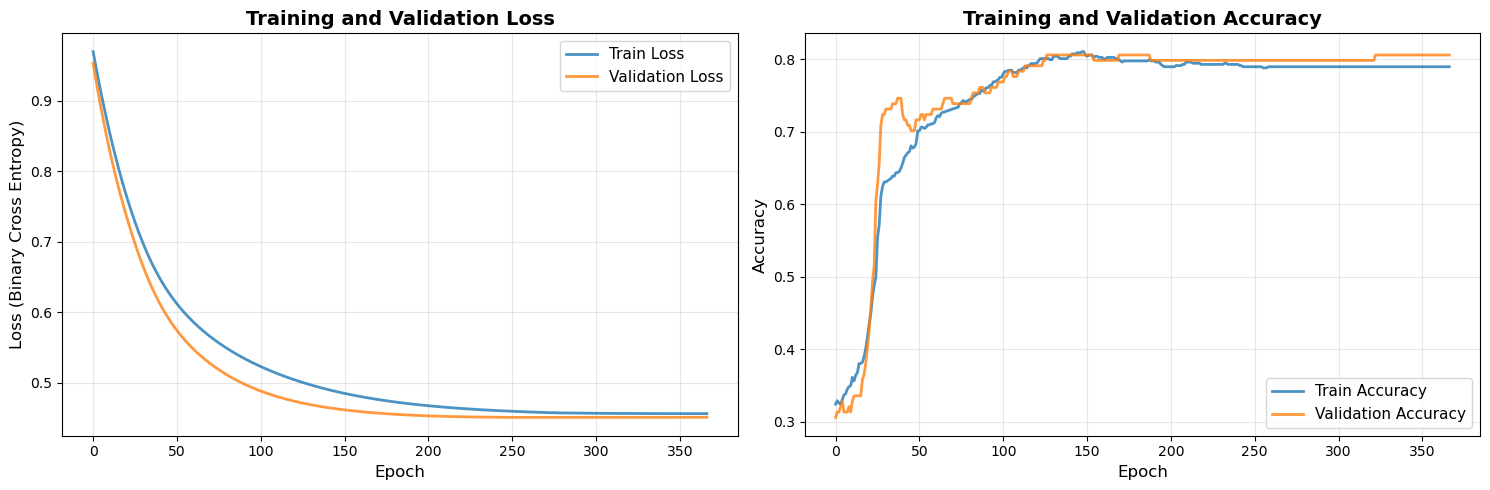

Final Training Accuracy: 0.7897
Final Validation Accuracy: 0.8060


In [22]:
# Plot Loss and Accuracy over epochs
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
axes[0].plot(train_losses, label='Train Loss', alpha=0.8, linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', alpha=0.8, linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (Binary Cross Entropy)', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot Accuracy
axes[1].plot(train_accuracies, label='Train Accuracy', alpha=0.8, linewidth=2)
axes[1].plot(val_accuracies, label='Validation Accuracy', alpha=0.8, linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

#### Visualize prediction distributions for training and test sets

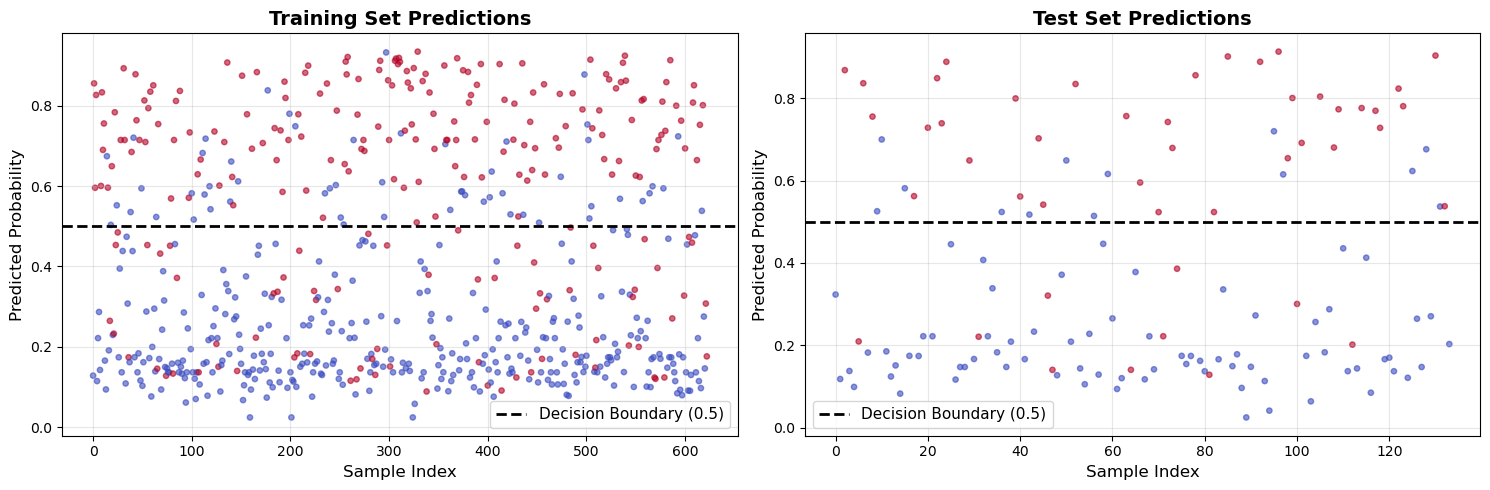

In [23]:
# Visualize predictions distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

with torch.no_grad():
    # Training predictions
    z_train = X_train @ W + b
    y_pred_train = torch.sigmoid(z_train).cpu().numpy()
    
    # Test predictions
    z_test = X_test @ W + b
    y_pred_test = torch.sigmoid(z_test).cpu().numpy()

# Training set predictions
axes[0].scatter(range(len(y_train)), y_pred_train, alpha=0.6, s=15, c=y_train.cpu().numpy(), cmap='coolwarm')
axes[0].axhline(y=0.5, color='black', linestyle='--', lw=2, label='Decision Boundary (0.5)')
axes[0].set_xlabel('Sample Index', fontsize=12)
axes[0].set_ylabel('Predicted Probability', fontsize=12)
axes[0].set_title('Training Set Predictions', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Test set predictions
axes[1].scatter(range(len(y_test)), y_pred_test, alpha=0.6, s=15, c=y_test.cpu().numpy(), cmap='coolwarm')
axes[1].axhline(y=0.5, color='black', linestyle='--', lw=2, label='Decision Boundary (0.5)')
axes[1].set_xlabel('Sample Index', fontsize=12)
axes[1].set_ylabel('Predicted Probability', fontsize=12)
axes[1].set_title('Test Set Predictions', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Final Model Evaluation

In [24]:
# Final Evaluation on Train, Validation, and Test sets
with torch.no_grad():
    # Training set
    z_train = X_train @ W + b
    y_pred_train = torch.sigmoid(z_train)
    y_pred_train_class = (y_pred_train >= 0.5).float()
    train_accuracy = (y_pred_train_class == y_train).float().mean().item()
    
    # Validation set
    z_val = X_val @ W + b
    y_pred_val = torch.sigmoid(z_val)
    y_pred_val_class = (y_pred_val >= 0.5).float()
    val_accuracy = (y_pred_val_class == y_val).float().mean().item()
    
    # Test set
    z_test = X_test @ W + b
    y_pred_test = torch.sigmoid(z_test)
    y_pred_test_class = (y_pred_test >= 0.5).float()
    test_accuracy = (y_pred_test_class == y_test).float().mean().item()
    
    print("="*60)
    print("FINAL MODEL PERFORMANCE")
    print("="*60)
    print(f"Training Accuracy:   {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
    print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
    print(f"Test Accuracy:       {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print("="*60)

FINAL MODEL PERFORMANCE
Training Accuracy:   0.7897 (78.97%)
Validation Accuracy: 0.7985 (79.85%)
Test Accuracy:       0.8284 (82.84%)


####  Example prediction for a new passenger

Features: [Pclass, Sex, Age, SibSp, Parch, Fare, Embarked_Q, Embarked_S]

3rd class, male, 25 years old, no family, low fare, embarked at Southampton

In [ ]:

new_passenger = np.array([[3, 1, 25, 0, 0, 7.25, 0, 1]])  
X_mean = data[features].values.astype(float).mean(axis=0)
X_std = data[features].values.astype(float).std(axis=0)
new_passenger_normalized = (new_passenger - X_mean) / X_std
new_passenger_tensor = torch.FloatTensor(new_passenger_normalized).to(device)
with torch.no_grad():
    z_new = new_passenger_tensor @ W + b
    prob = torch.sigmoid(z_new)
    prediction = "Survived" if prob.item() >= 0.5 else "Died"
    print(f"Predicted probability of survival: {prob.item():.4f}")
    print(f"Prediction: {prediction}")

Predicted probability of survival: 0.1473
Prediction: Died
